<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_07/08_keras_tuner_hparam_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Install Keras Tuner
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [2]:
# Step 2: Imports
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

In [3]:
# Step 3: Load and Prepare Data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train[..., tf.newaxis].astype("float32") / 255.0
x_test = x_test[..., tf.newaxis].astype("float32") / 255.0

y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Step 4: Define Model Builder for Keras Tuner
def model_builder(hp):
    model = models.Sequential()
    model.add(layers.Input(shape=(28, 28, 1)))
    model.add(layers.Flatten())

    # Tune number of units
    hp_units = hp.Int('units', min_value=64, max_value=256, step=32)
    model.add(layers.Dense(units=hp_units, activation='relu'))

    # Tune dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    model.add(layers.Dropout(rate=hp_dropout))

    model.add(layers.Dense(10, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [5]:
# Step 5: Initialize Tuner

tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='kt_dir',
    project_name='kt_fashion_mnist'
)

In [6]:
# Step 6: Early Stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


In [7]:
# Step 7: Search Best Hyperparameters
tuner.search(x_train, y_train_cat, epochs=10, validation_data=(x_test, y_test_cat), callbacks=[stop_early])

Trial 30 Complete [00h 01m 01s]
val_accuracy: 0.8738999962806702

Best val_accuracy So Far: 0.8830999732017517
Total elapsed time: 00h 17m 48s


In [8]:
# Step 8: Get Best Model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best units: {best_hps.get('units')}, Dropout: {best_hps.get('dropout')}, LR: {best_hps.get('learning_rate')}")

Best units: 256, Dropout: 0.4, LR: 0.001


In [9]:
# Step 9: Train Best Model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7522 - loss: 0.6970 - val_accuracy: 0.8495 - val_loss: 0.4193
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8454 - loss: 0.4282 - val_accuracy: 0.8613 - val_loss: 0.3923
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8571 - loss: 0.3906 - val_accuracy: 0.8619 - val_loss: 0.3773
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8670 - loss: 0.3682 - val_accuracy: 0.8675 - val_loss: 0.3712
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8692 - loss: 0.3566 - val_accuracy: 0.8732 - val_loss: 0.3573
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8735 - loss: 0.3397 - val_accuracy: 0.8696 - val_loss: 0.3662
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8781 - loss: 0.3316 - val_accuracy: 0.8670 - val_loss: 0.3668
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8782 - loss: 0.3299 

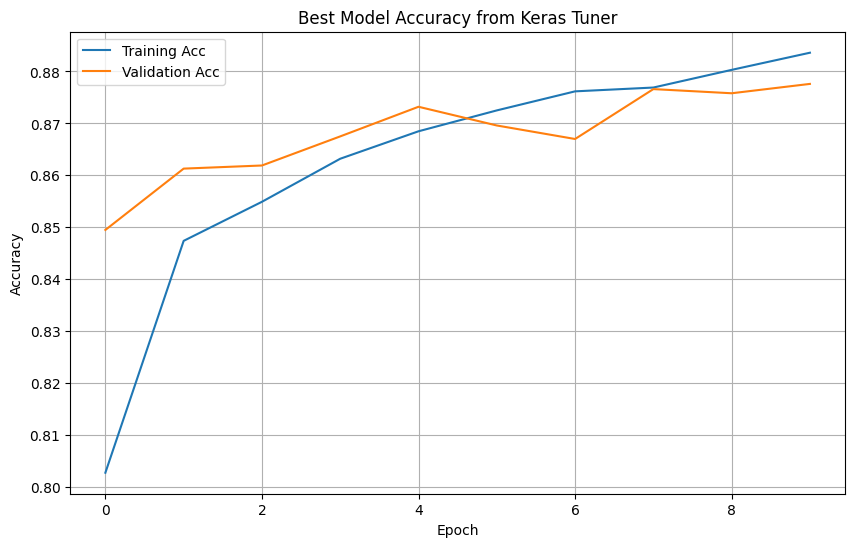

In [10]:
# Step 10: Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.title("Best Model Accuracy from Keras Tuner")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()